# https://scib-metrics.readthedocs.io/en/latest/notebooks/lung_example.html

Random seed set as 42
/home/figo/software/python_libs/scbiot/examples
/home/figo/software/python_libs/scbiot


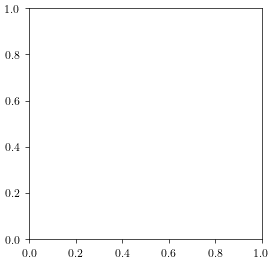

In [6]:
import anndata
anndata.settings.allow_write_nullable_strings = True
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
import torch
import os
import pandas as pd
from umap import UMAP
# %pip install scib-metrics
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
# %pip install scimorph
from scimorph.theme_publication import theme_publication
from scimorph.utils import set_seed
theme_publication()
set_seed(42)

from pathlib import Path
dir = Path.cwd()
print(dir)
parent_dir = dir.parent
print(parent_dir)


In [7]:
adata_path = f"{dir}/inputs/HNSC_annotation.h5ad"
adata = sc.read(
    adata_path,
    backup_url="https://figshare.com/ndownloader/files/59759420"
)

In [8]:
order = adata.obs['cell_type'].value_counts().index.tolist()
adata.obs['cell_type'] = pd.Categorical(adata.obs['cell_type'], categories=order, ordered=True)

In [9]:

adata.obs['hpv_status'] = pd.Categorical(adata.obs['hpv_status'], categories=['Healthy_donor', 'HPV_negative', 'HPV_positive'], ordered=True)

/tmp/ipykernel_631318/3236594171.py:30: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(adata.obs[key]):


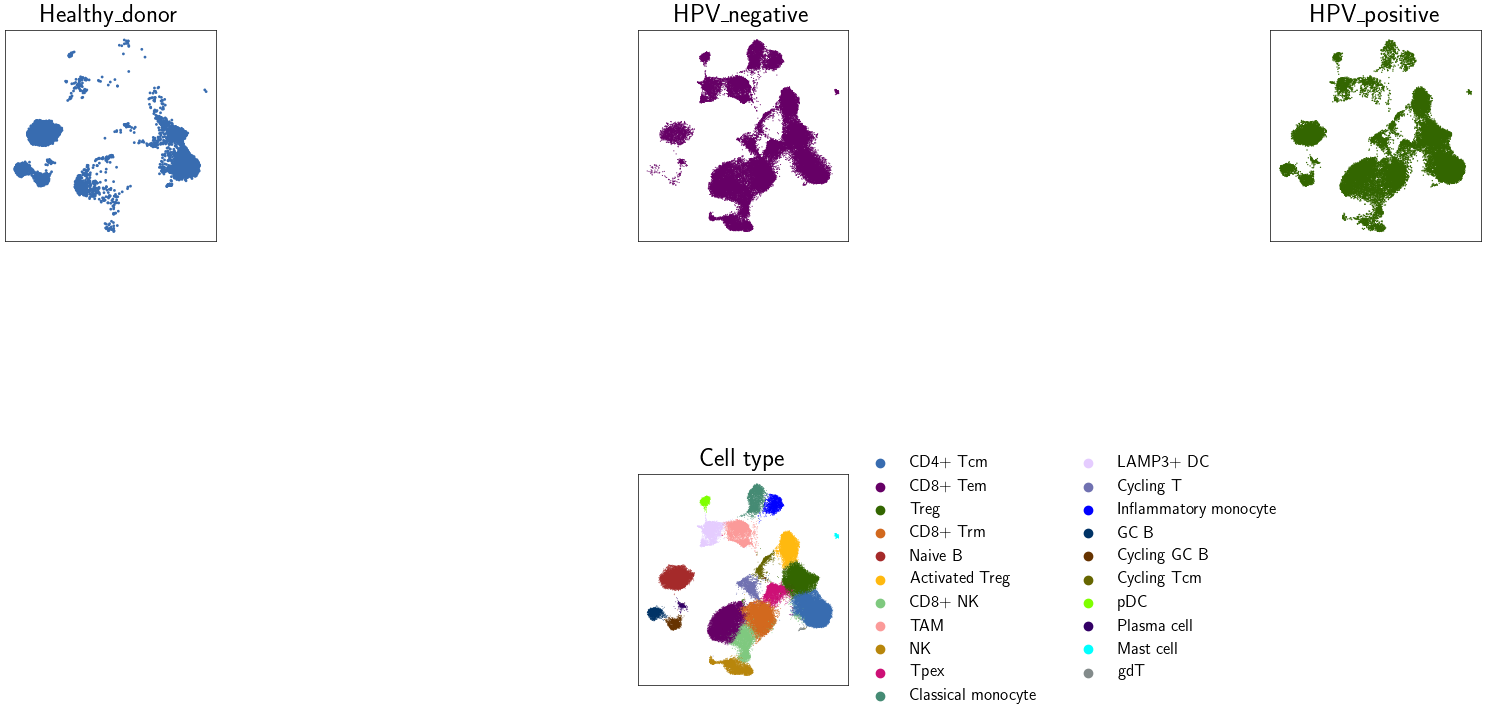

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scanpy as sc
import pandas as pd
from itertools import islice, cycle

# --- Matplotlib styling ---
if 'publication' in plt.style.available:
    plt.style.use('publication')

mpl.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.titlesize': 18,
    'legend.fontsize': 12,
    'legend.title_fontsize': 12,
    'figure.dpi': 100,
    'savefig.dpi': 300,
})

# --- Keys and methods ---
BATCH_KEY = "hpv_status"
LABEL_KEY = "cell_type"
methods   = ["scBIOT"]

# --- Ensure categorical dtype ---
for key in (BATCH_KEY, LABEL_KEY):
    if key not in adata.obs:
        raise KeyError(f"{key!r} not in adata.obs")
    if not pd.api.types.is_categorical_dtype(adata.obs[key]):
        adata.obs[key] = adata.obs[key].astype("category")

# --- Optional: reorder LABEL_KEY by descending frequency ---
order = adata.obs[LABEL_KEY].value_counts().index.tolist()
adata.obs[LABEL_KEY] = adata.obs[LABEL_KEY].cat.reorder_categories(order, ordered=True)

# --- Override Scanpy's palette using Matplotlib style colors ---
def set_palette_from_mpl_style(adata, key):
    cats = list(adata.obs[key].cat.categories)
    style_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']
    adata.uns[f"{key}_colors"] = list(islice(cycle(style_colors), len(cats)))

set_palette_from_mpl_style(adata, BATCH_KEY)
set_palette_from_mpl_style(adata, LABEL_KEY)

# --- Get categories to split the top row ---
batch_cats = list(adata.obs[BATCH_KEY].cat.categories)

# --- Layout: 2 rows (top: 3 batch-specific plots, bottom: cell_type), columns = max(3, len(methods)) ---
ncols = max(3, len(methods))
fig, axes = plt.subplots(
    2, ncols,
    figsize=(5 * ncols, 9),
    squeeze=False
)

# --- Plot: first row, one per BATCH category ---
basis = f"X_umap_{methods[0]}"
if basis not in adata.obsm:
    raise KeyError(f"{basis} not in adata.obsm")

for i, cat in enumerate(batch_cats):
    subset = adata[adata.obs[BATCH_KEY] == cat]
    sc.pl.embedding(
        subset, basis=basis, color=BATCH_KEY,
        frameon=True, ax=axes[0, i], show=False,
        legend_loc=None, title=cat
    )

# --- Second row: full cell type UMAP ---
sc.pl.embedding(
    adata, basis=basis, color=LABEL_KEY,
    frameon=True, ax=axes[1, 1], show=False,
    legend_loc="right margin", title="Cell type"
)

# Hide unused subplots if ncols > 3
for idx in range(len(batch_cats), ncols):
    axes[0, idx].axis("off")
for idx in range(ncols):
    if idx != 1:  # only column 1 has cell_type plot
        axes[1, idx].axis("off")

# --- Square layout ---
for ax in axes.ravel():
    if hasattr(ax, "set_box_aspect"):
        ax.set_box_aspect(1)

for ax in fig.axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("")
        ax.set_ylabel("")

plt.tight_layout()
plt.show()

# Optional save
# fig.savefig(f"{parent_dir}/plots/IM07/HNSC_split_batch_celltype.pdf", bbox_inches="tight")


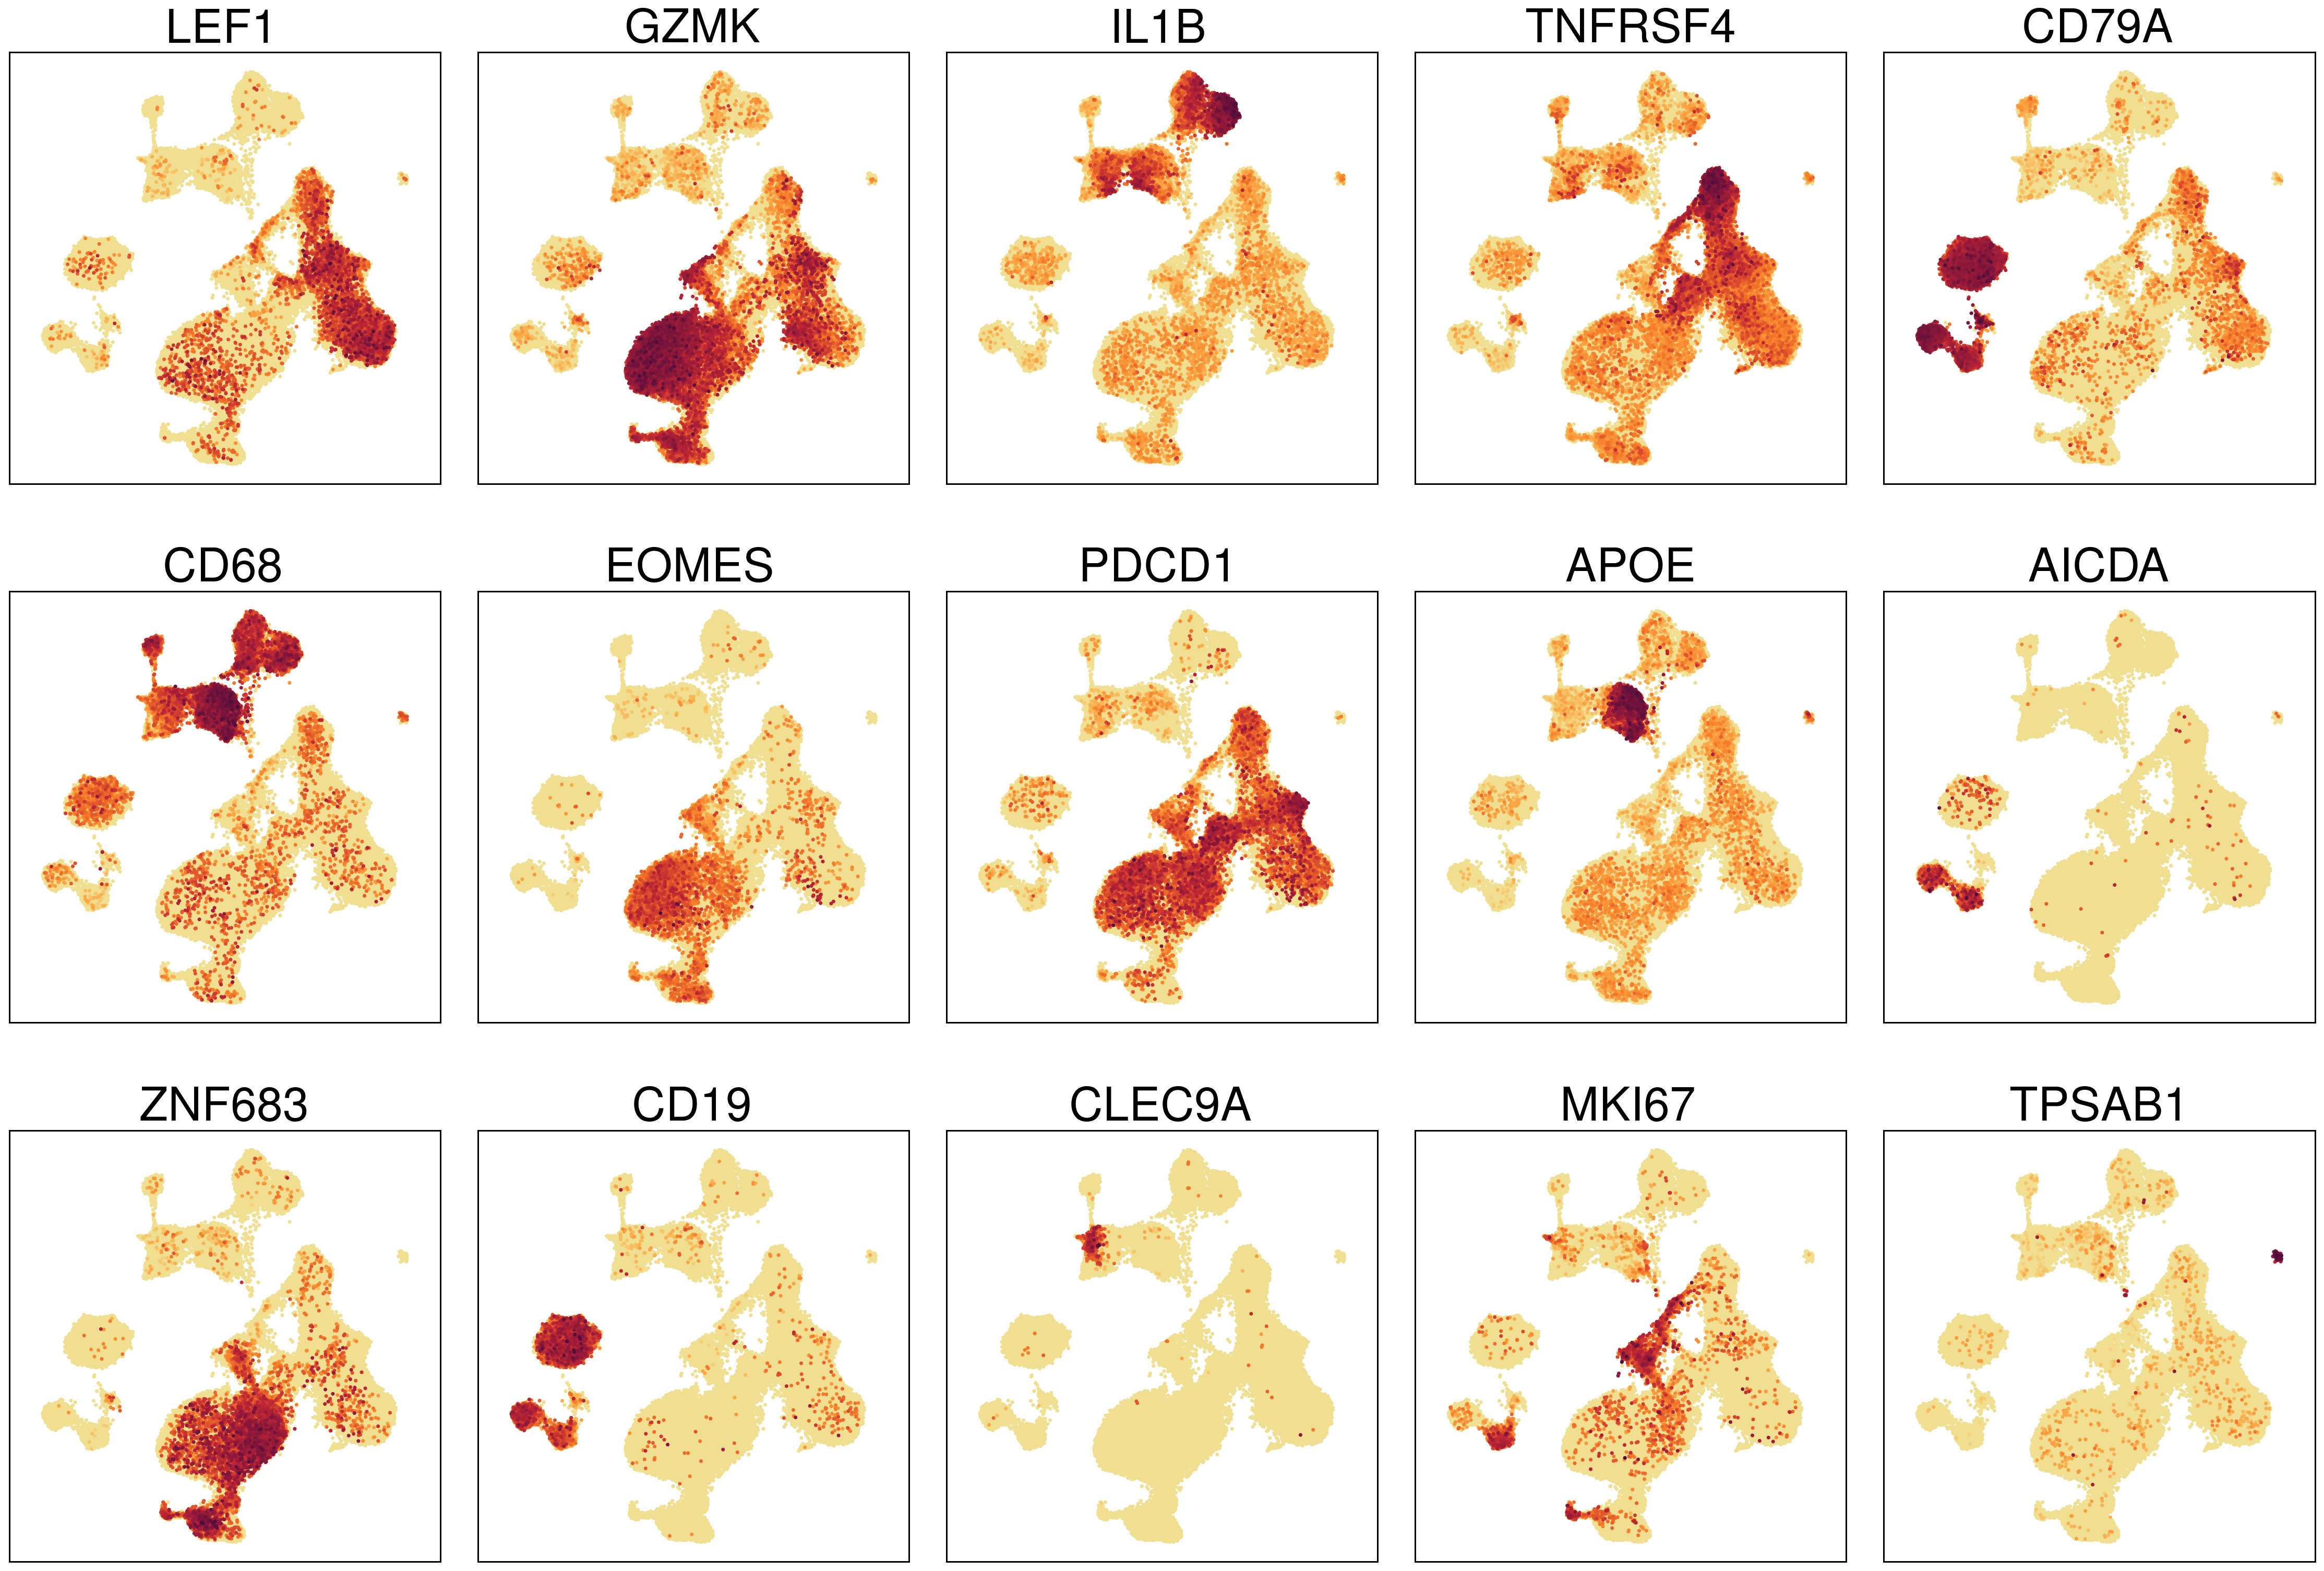

In [12]:
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math

def _as_cmap(cmap):
    if isinstance(cmap, (list, tuple, np.ndarray)):
        return mpl.colors.LinearSegmentedColormap.from_list("custom", list(cmap))
    if isinstance(cmap, mpl.colors.Colormap):
        return cmap
    return mpl.cm.get_cmap(str(cmap))

def plot_feature_umaps(
    adata, genes, *, ncols=5, s=8,
    cmap=("#F1DF91","#F8C063","#FA9F3E","#F57828","#DD4F2C","#BF2633","#991B39","#72133B","#4C0D3D"),
    layer=None, vmin=0, vmax=None, dpi=180, save=None,
    ax_size=2.8, fontsize=14, title_fontsize=None,
    gap=0.04  # NEW: controls space between subplots (both directions)
):
    title_fontsize = fontsize + 2 if title_fontsize is None else title_fontsize
    sc.set_figure_params(dpi=dpi, facecolor="white", fontsize=fontsize)
    mpl.rcParams.update({
        "figure.facecolor": "white",
        "axes.facecolor": "white",
        "savefig.bbox": "tight",
        "axes.titlesize": title_fontsize,
        "legend.fontsize": fontsize,
        "legend.title_fontsize": fontsize,
        "axes.titlepad": 1.5,  # tighter title spacing
    })

    fig = sc.pl.umap(
        adata,
        color=genes,
        ncols=ncols,
        frameon=True,
        colorbar_loc=None,
        color_map=_as_cmap(cmap),
        vmin=vmin,
        vmax=vmax,
        s=s,
        layer=layer,
        wspace=gap,     # horizontal spacing
        show=False,
        return_fig=True,
    )

    for ax in fig.axes:
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_xlabel(""); ax.set_ylabel("")
        ax.set_aspect("equal", adjustable="box")
        ax.set_box_aspect(1)
        for sp in ax.spines.values(): sp.set_linewidth(0.6)

    n_rows = math.ceil(len(genes) / ncols)
    # smaller outer margins + reduced inter-panel gaps
    fig.set_size_inches(ncols * ax_size + 0.6, n_rows * ax_size + 0.6)
    fig.subplots_adjust(left=0.02, right=0.98, bottom=0.04, top=0.96,
                        wspace=gap, hspace=gap)

    if save:
        fig.savefig(save, dpi=dpi)
    plt.show()

# Example
genes = ["LEF1","GZMK","IL1B","TNFRSF4","CD79A","CD68","EOMES","PDCD1","APOE","AICDA","ZNF683","CD19","CLEC9A","MKI67","TPSAB1"]
plot_feature_umaps(adata, genes, ncols=5, ax_size=3.0, fontsize=16, title_fontsize=18,
                   gap=0.01, save=f"{dir}/inputs/HNSCC_featurepanel_umap.pdf")
